# Phase 2

# Fraud order detection

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


In [32]:
df = pd.read_csv('DataCoSupplyChainDataset.csv', encoding='ANSI')
df.head()


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [33]:
df['Fraud'] = df['Order Status'].apply(lambda x: 1 if x == 'SUSPECTED_FRAUD' else 0)
print(df['Fraud'].value_counts())

Fraud
0    176457
1      4062
Name: count, dtype: int64


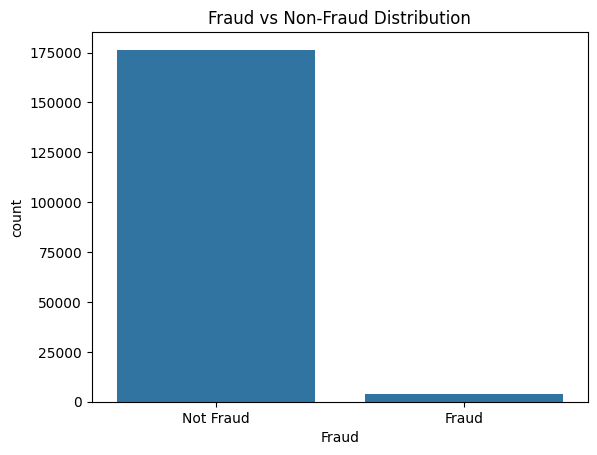

In [34]:
sns.countplot(data=df, x='Fraud')
plt.title("Fraud vs Non-Fraud Distribution")
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()

In [35]:
selected_features = [
    "Days for shipping (real)", "Days for shipment (scheduled)", "Benefit per order",
    "Sales per customer", "Late_delivery_risk", "Order Item Discount",
    "Order Item Discount Rate", "Order Item Product Price", "Order Item Quantity",
    "Order Item Total", "Order Profit Per Order", "Product Price", "Shipping Mode"
]

# Encode "Shipping Mode"
label_encoder = LabelEncoder()
df["Shipping Mode"] = label_encoder.fit_transform(df["Shipping Mode"])

In [36]:
X = df[selected_features]
y = df["Fraud"]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [38]:
model_imbalanced = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_imbalanced.fit(X_train, y_train)

c:\Users\shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [39]:
X_train.shape

(144415, 13)

In [40]:
X_test.shape

(36104, 13)

In [41]:
sample = X_test.iloc[35000]           # Get the 35000th test sample (if it exists)
pred = model_imbalanced.predict([sample])  # Predict returns a list with 1 value
print(f"Prediction for row: {pred[0]}")  # Access the 1st and only prediction

Prediction for row: 0


=== Imbalanced Model ===
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     35292
           1       0.53      0.31      0.39       812

    accuracy                           0.98     36104
   macro avg       0.76      0.65      0.69     36104
weighted avg       0.97      0.98      0.98     36104

Confusion Matrix:
 [[35067   225]
 [  560   252]]
Accuracy Score: 0.9782572568136495
ROC AUC Score: 0.9015558759880272


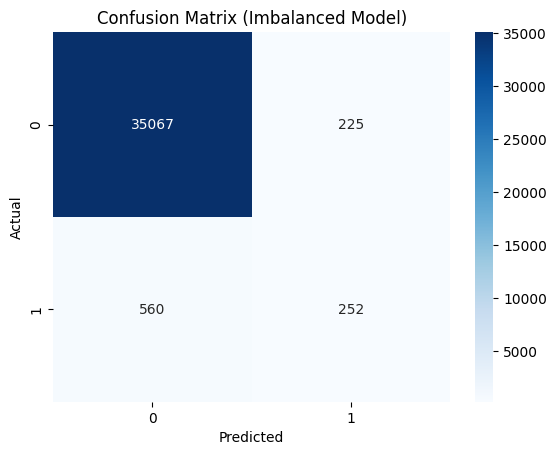

In [42]:
y_pred_imbal = model_imbalanced.predict(X_test)
y_proba_imbal = model_imbalanced.predict_proba(X_test)[:, 1]

print("=== Imbalanced Model ===")
print("Classification Report:\n", classification_report(y_test, y_pred_imbal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_imbal))
print("Accuracy Score:", accuracy_score(y_test, y_pred_imbal))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_imbal))

# Optional: Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_imbal), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Imbalanced Model)")
plt.show()


- True Negatives  -  
Model correctly predicted 35,067 non-fraud orders as "Not Fraud."
Good news: The model performs extremely well in identifying normal transactions.
- False Positives  -  
The model predicted 225 non-fraud orders as fraud by mistake.
Bad for customer experience – A legitimate transaction might be flagged as fraud, causing frustration.
- False Negatives -  
560 fraud cases were wrongly classified as non-fraud.
Very bad for fraud detection – This means 69% of real frauds go undetected (this is why recall is low).
- True Positives  -  
The model correctly detected 252 fraud cases.

# ROC Curve (Receiver Operating Characteristic Curve)
The ROC curve shows how well your model separates fraud from non-fraud cases.
It plots:
True Positive Rate (TPR) → Recall (How many frauds were correctly identified?)
False Positive Rate (FPR) → How many normal orders were wrongly flagged as fraud?
- AUC (Area Under the Curve)
The AUC score is the area under the ROC curve.
AUC = 1.0 (100%) → Perfect model (best case scenario).
AUC = 0.5 (50%) → Random guessing (worst case scenario).
our AUC = 0.90 → our model is 90% good at distinguishing fraud from non-fraud.

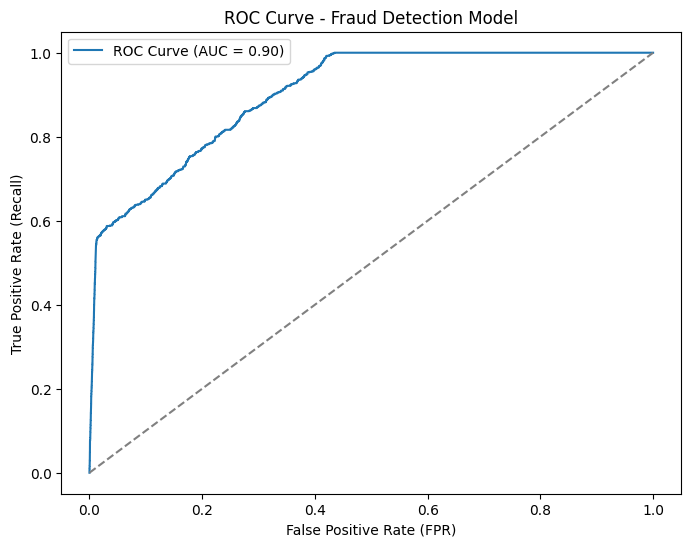

In [43]:
from sklearn.metrics import roc_curve

# Get prediction probabilities
y_proba = model_imbalanced.predict_proba(X_test)[:, 1]  # Probability of being fraud

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random chance line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Fraud Detection Model")
plt.legend()
plt.show()

# Key Problems with Fraud Detection
- Precision for fraud (53%):
If the model says "fraud," it's correct only 53% of the time.
False positives (FP = 225) → Some legitimate transactions are wrongly flagged as fraud.
- Recall for fraud (31%):
The model is only catching 31% of actual fraud cases.
This is very bad for fraud detection – we need a higher recall!

# SMOTE (50-50)

In [44]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Check new class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())


Class distribution after SMOTE:
Fraud
0    141165
1    141165
Name: count, dtype: int64


C:\Users\shiva\AppData\Local\Temp\ipykernel_23024\36414830.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Not Fraud", "Fraud"])
C:\Users\shiva\AppData\Local\Temp\ipykernel_23024\36414830.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["Not Fraud", "Fraud"])


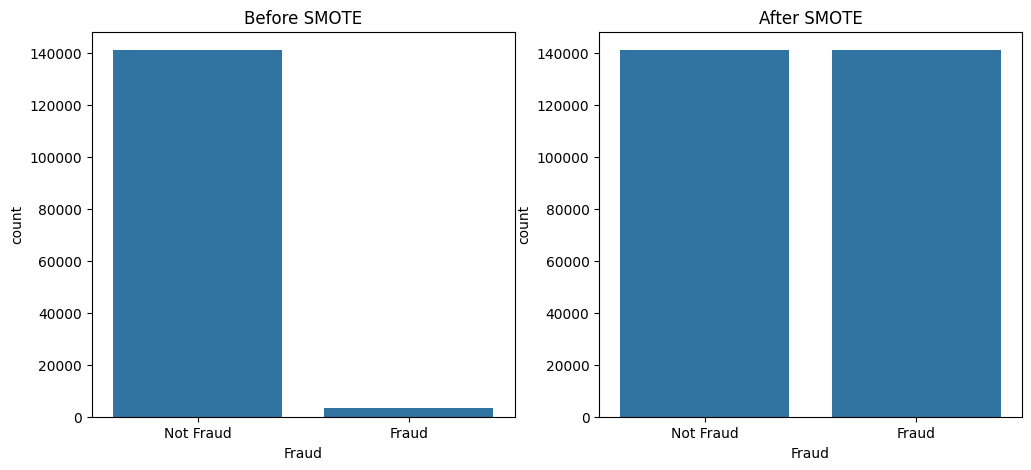

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Before SMOTE")
axes[0].set_xticklabels(["Not Fraud", "Fraud"])

# After SMOTE
sns.countplot(x=y_train_resampled, ax=axes[1])
axes[1].set_title("After SMOTE")
axes[1].set_xticklabels(["Not Fraud", "Fraud"])

plt.show()

In [46]:
from xgboost import XGBClassifier

# Train a new XGBoost model on balanced data
model_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_smote.fit(X_train_resampled, y_train_resampled)

c:\Users\shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Predict using the model trained on SMOTE data
y_pred_smote = model_smote.predict(X_test)
y_proba_smote = model_smote.predict_proba(X_test)[:, 1]

# Print classification report
print("=== Model After SMOTE ===")
print("Classification Report:\n", classification_report(y_test, y_pred_smote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("Accuracy Score:", accuracy_score(y_test, y_pred_smote))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_smote))


=== Model After SMOTE ===
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     35292
           1       0.41      0.52      0.46       812

    accuracy                           0.97     36104
   macro avg       0.70      0.75      0.72     36104
weighted avg       0.98      0.97      0.97     36104

Confusion Matrix:
 [[34696   596]
 [  393   419]]
Accuracy Score: 0.9726069133614004
ROC AUC Score: 0.8985063878052716


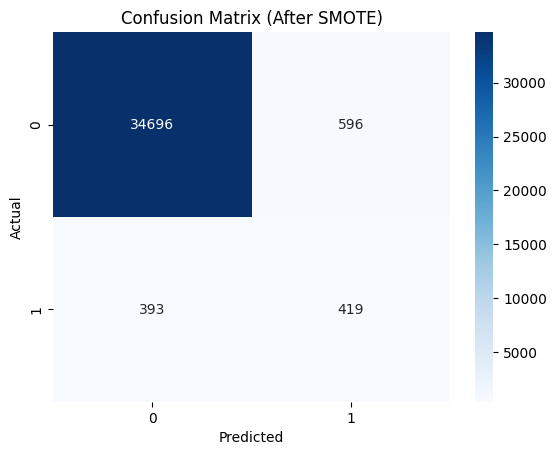

In [48]:
sns.heatmap(confusion_matrix(y_test, y_pred_smote), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (After SMOTE)")
plt.show()


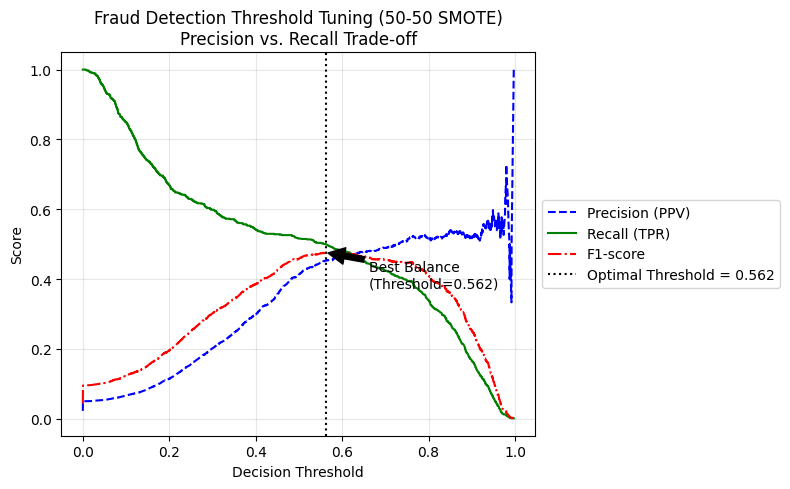

Optimal Decision Threshold: 0.5621


In [49]:
# Generate predicted probabilities for 50-50 SMOTE model
y_proba_smote = model_smote.predict_proba(X_test)[:, 1]  # Probabilities for fraud class

# Calculate precision-recall curve and F1-scores
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_smote)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Avoid division by zero

# Find optimal threshold (max F1-score)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Plot the threshold curve
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision (PPV)')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall (TPR)') 
plt.plot(thresholds, f1_scores[:-1], 'r-.', label='F1-score')
plt.axvline(optimal_threshold, color='k', linestyle=':', 
            label=f'Optimal Threshold = {optimal_threshold:.3f}')

# Customize plot
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Fraud Detection Threshold Tuning (50-50 SMOTE)\nPrecision vs. Recall Trade-off')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Annotate the optimal point
plt.annotate(f'Best Balance\n(Threshold={optimal_threshold:.3f})',
             xy=(optimal_threshold, f1_scores[optimal_idx]),
             xytext=(optimal_threshold+0.1, f1_scores[optimal_idx]-0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

print(f"Optimal Decision Threshold: {optimal_threshold:.4f}")

# 30% SMOTE

In [50]:

# Apply SMOTE with 30% fraud cases instead of full balance
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_resampled_30, y_train_resampled_30 = sm.fit_resample(X_train, y_train)

# Check new class distribution
print("Class distribution after 30% SMOTE:")
print(y_train_resampled_30.value_counts())

Class distribution after 30% SMOTE:
Fraud
0    141165
1     42349
Name: count, dtype: int64


C:\Users\shiva\AppData\Local\Temp\ipykernel_23024\1215833649.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Not Fraud", "Fraud"])
C:\Users\shiva\AppData\Local\Temp\ipykernel_23024\1215833649.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["Not Fraud", "Fraud"])


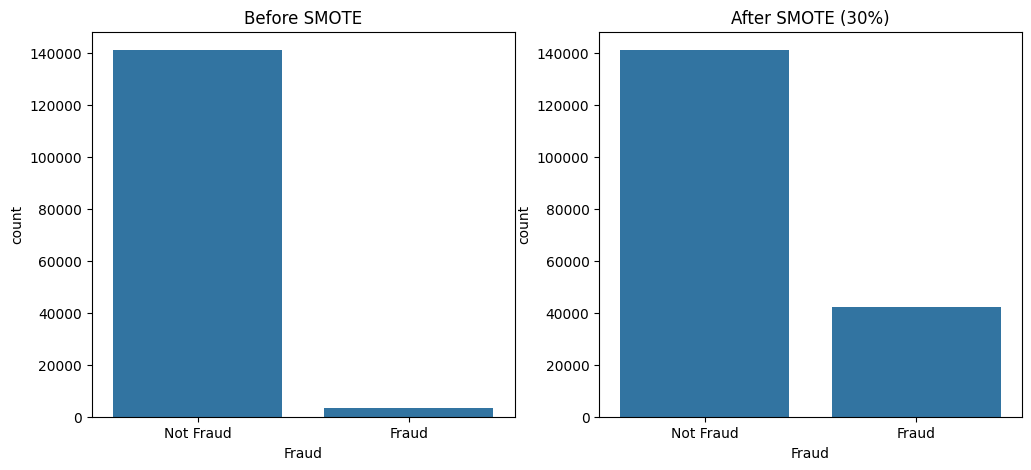

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Before SMOTE")
axes[0].set_xticklabels(["Not Fraud", "Fraud"])

# After SMOTE (30%)
sns.countplot(x=y_train_resampled_30, ax=axes[1])
axes[1].set_title("After SMOTE (30%)")
axes[1].set_xticklabels(["Not Fraud", "Fraud"])

plt.show()


In [52]:
from xgboost import XGBClassifier

# Train a new XGBoost model on reduced SMOTE data
model_smote_30 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_smote_30.fit(X_train_resampled_30, y_train_resampled_30)


c:\Users\shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [53]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Predict using the model trained on 30% SMOTE data
y_pred_smote_30 = model_smote_30.predict(X_test)
y_proba_smote_30 = model_smote_30.predict_proba(X_test)[:, 1]

# Print classification report
print("=== Model After 30% SMOTE ===")
print("Classification Report:\n", classification_report(y_test, y_pred_smote_30))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote_30))
print("Accuracy Score:", accuracy_score(y_test, y_pred_smote_30))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_smote_30))


=== Model After 30% SMOTE ===
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     35292
           1       0.51      0.49      0.50       812

    accuracy                           0.98     36104
   macro avg       0.75      0.74      0.74     36104
weighted avg       0.98      0.98      0.98     36104

Confusion Matrix:
 [[34908   384]
 [  417   395]]
Accuracy Score: 0.9778140926213162
ROC AUC Score: 0.8980933488603734


- If fraud prevention is the top priority → Use 50-50 SMOTE.
- If minimizing false alarms is more important → Use 30% SMOTE.

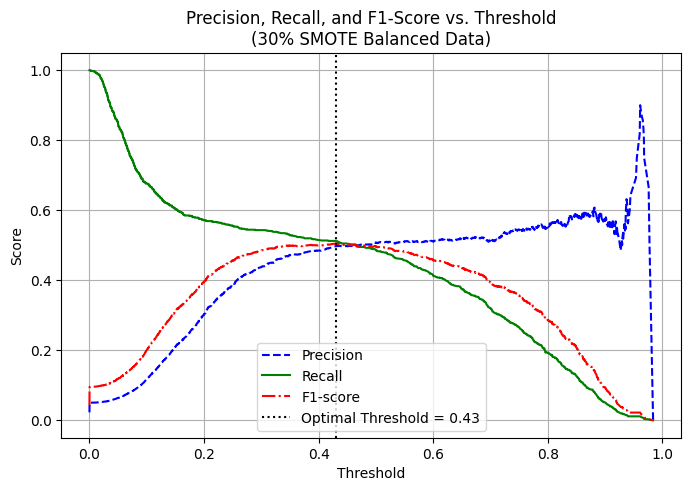

Optimal Threshold (Max F1-Score): 0.4301


In [54]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# Generate predicted probabilities (if not already done)
y_proba_smote_30 = model_smote_30.predict_proba(X_test)[:, 1]  # Probability of class 1 (fraud)

# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_smote_30)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Avoid division by zero

# Find optimal threshold (max F1-score)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Plot threshold curve
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall') 
plt.plot(thresholds, f1_scores[:-1], 'r-.', label='F1-score')
plt.axvline(optimal_threshold, color='k', linestyle=':', 
            label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score vs. Threshold\n(30% SMOTE Balanced Data)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal Threshold (Max F1-Score): {optimal_threshold:.4f}")

In [56]:
import pickle

# Save the trained fraud detection model
with open('fraud_model.pkl', 'wb') as f:
    pickle.dump(model_imbalanced, f)

print("✅ fraud_model.pkl saved successfully.")

✅ fraud_model.pkl saved successfully.


In [57]:
pip install flask


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: flask in c:\users\shiva\appdata\local\programs\python\python312\lib\site-packages (3.1.0)




[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
